# Exploration of Structure-Aware Line Segment Classification

[Link to the slides](https://docs.google.com/presentation/d/1a_c7ad2dueD3v1S-io3ree2PZ7l1lJwAjxdZ9Dhj0NY/edit#slide=id.g1bb67da435b_0_13)

## Next steps :
- Implement script to download wireframe dataset
- Use a subset of Hypersim
- run lsd and letr on the hypersim dataset subset
- Find a way to compare results
- Implement Dataloader
- Implement Model

### Imports

In [ ]:
#install PIL
!pip install Pillow

In [43]:
# -*- coding: utf-8 -*-
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pytlsd
from skimage.transform import pyramid_reduce
import pickle
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from IPython.display import display
from PIL import Image

2022-12-21 17:37:55.074420: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-21 17:37:55.436726: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/alexis/miniconda3/envs/bert/lib/python3.10/site-packages/cv2/../../lib64:
2022-12-21 17:37:55.436750: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-21 17:37:55.485698: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when on

## PYTLSD

In [42]:
NOTDEF = -1024.0

def get_thresholded_grad(resized_img):
    modgrad = np.full(resized_img.shape, NOTDEF, np.float64)
    anglegrad = np.full(resized_img.shape, NOTDEF, np.float64)

    # A B
    # C D
    A, B, C, D = resized_img[:-1, :-1], resized_img[:-1, 1:], resized_img[1:, :-1], resized_img[1:, 1:]
    gx = B + D - (A + C)  # horizontal difference
    gy = C + D - (A + B)  # vertical difference

    threshold = 5.2262518595055063
    modgrad[:-1, :-1] = 0.5 * np.sqrt(gx ** 2 + gy ** 2)
    anglegrad[:-1, :-1] = np.arctan2(gx, -gy)
    anglegrad[modgrad <= threshold] = NOTDEF
    return gx, gy, modgrad, anglegrad


In [49]:
def analyze_image_pytlsd(image_path='pytlsd/resources/ai_001_001.frame.0000.color.jpg'):
    gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    flt_img = gray.astype(np.float64)

    scale_down = 0.8
    resized_img = pyramid_reduce(flt_img, 1 / scale_down, 0.6)

    # Get image gradients
    gx, gy, gradnorm, gradangle = get_thresholded_grad(resized_img)

    segments = pytlsd.lsd(resized_img, 1.0, gradnorm=gradnorm, gradangle=gradangle)
    segments /= scale_down

    # plt.title("Gradient norm")
    # plt.imshow(gradnorm[:-1, :-1])
    # plt.colorbar()
    # plt.figure()
    # gradangle[gradangle == NOTDEF] = -5
    # plt.title("Thresholded gradient angle")
    # plt.imshow(gradangle[:-1, :-1])
    # plt.colorbar()

    img_color = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
    for segment in segments:
        cv2.line(img_color, (int(segment[0]), int(segment[1])), (int(segment[2]), int(segment[3])), (0, 255, 0))

    return cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB), segments, gradnorm, gradangle

## WIREFRAME Dataset

### Download 

Download the dataset ([link](https://onedrive.live.com/?authkey=%21AGPMjJtoh%5FIn5l8&id=FD0F423C6AB601A4%217290&cid=FD0F423C6AB601A4))
and place it in the `wireframe_dataset` folder.

- Data Structure  
    Each .pkl file contains the annotated wireframe of an image, and it consists of the following variables:  
    ```shell
    *.pkl  
        |-- imagename: 	the name of the image  
        |-- img:         the image data  
        |-- points:      the set of points in the wireframe, each point is represented by its (x,y)-coordinates in the image  
        |-- lines:       the set of lines in the wireframe, each line is represented by the indices of its two end-points  
        |-- pointlines:     the set of associated lines of each point        
        |-- pointlines_index:       line indexes of lines in 'pointlines'  
        |-- junction:       the junction locations, derived from the 'points' and 'lines'  
        |-- theta:      the angle values of branches of each junction                   
    ```

In [50]:
# Load wireframe images

data_path = 'wireframe_dataset/pointlines/'
def load_img_points(idx):
    filename = data_path + f'{idx}.pkl'
    infile = open(filename,'rb')
    new_dict = pickle.load(infile)
    infile.close()

    im = new_dict['img']
    lines = new_dict['lines']
    points = new_dict['points']

    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    return im, lines, points

In [53]:
# Show wireframe images without and with lines

def print_original_and_image_with_line(id):
    im, lines, points = load_img_points(id)
    imb_before = im.copy()
    for idx, (i, j) in enumerate(lines, start=0):
     x1, y1 = points[i]
     x2, y2 = points[j]
     cv2.line(im, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2, cv2.LINE_8)

    img_path = 'wireframe_dataset/v1.1/train/'
    pytlsd_im = analyze_image_pytlsd(img_path + f'{id}.jpg')[0]
    # Plot the image
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    ax1.imshow(imb_before)
    ax1.set_title('Original Image')
    ax2.imshow(im)
    ax2.set_title('with GT lines')
    ax3.imshow(pytlsd_im)
    ax3.set_title('with PyTSLD lines')
    plt.show()

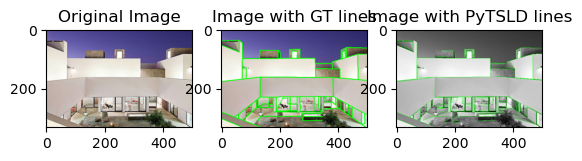

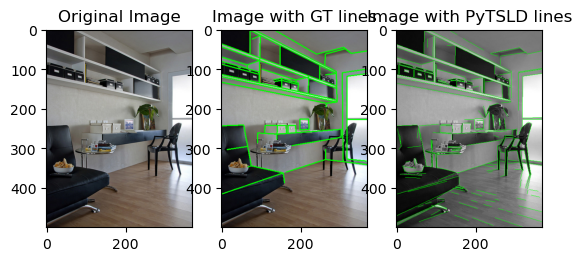

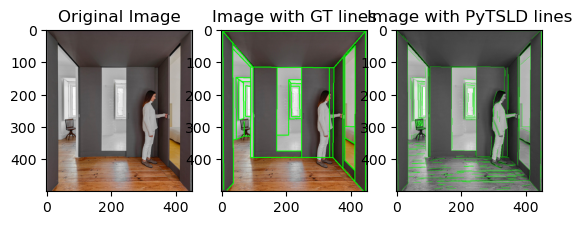

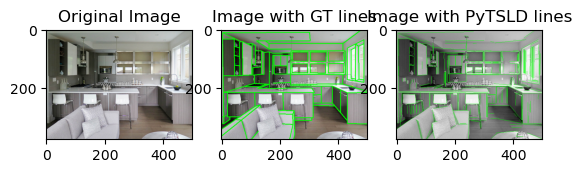

[ WARN:0@6216.987] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('wireframe_dataset/v1.1/train/00410976.jpg'): can't open/read file: check file path/integrity


AttributeError: 'NoneType' object has no attribute 'astype'

In [54]:
for file in os.listdir(data_path)[:10]:
    id = file.split('.')[0]
    print_original_and_image_with_line(id)


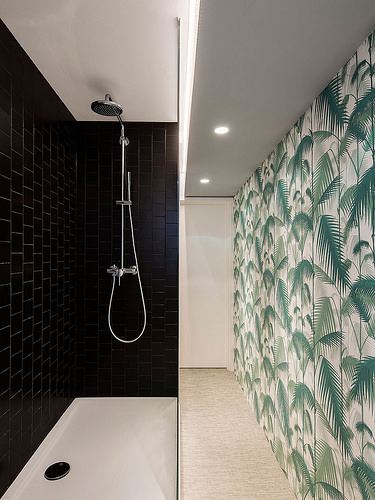

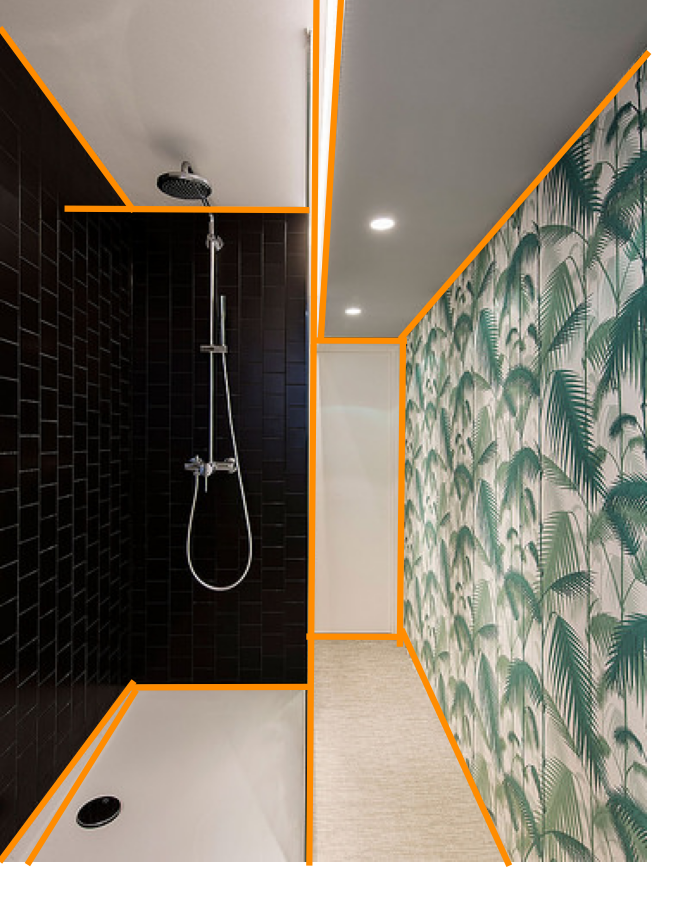

In [20]:

demo_img = Image.open('demo/demo.png')
letr_result = Image.open('demo/demo_letr_result.png')
display(demo_img)
display(letr_result)
images = [] # list of images we use as input
images.append(demo_img)

#### Preprocessing

In [21]:
#resize images
input_dimension_x = 512
input_dimension_y = 512
for image in images:
    image = letr_result.resize((input_dimension_x, input_dimension_y), Image.ANTIALIAS) #antialiasing to avoid pixelation


### Models 

In [27]:
#simple cnn classification
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(512, 512, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2, activation='softmax')) #softmax for classification
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 510, 510, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 255, 255, 32)     0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 253, 253, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 126, 126, 64)     0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 124, 124, 64)      36928     
                                                                 
 flatten_3 (Flatten)         (None, 984064)           

In [28]:
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam', loss=loss_function, metrics=['accuracy', 'f1_score'])

In [ ]:
history = model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))

#### Stacking LSD with LETR models -> allows for textural classification as well
#### Using new model using LETR for creating the dataset.

In [ ]:
#Using the Wireframe dataset (that already has structural lines detected) LETR for structural line detection. 